#  Pix2Pix for Image Colorization

This project implements a **Pix2Pix Generative Adversarial Network (GAN)** to **colorize grayscale images**.  
It learns a mapping from single-channel grayscale input to three-channel RGB output using paired image data.

---

##  Project Overview

- **Task**: Image-to-image translation – colorizing grayscale images using supervised learning.
- **Architecture**: 
  - **Generator**: U-Net with skip connections.
  - **Discriminator**: PatchGAN (classifies image patches as real/fake).
- **Input**: Grayscale image (`128x128x1`)
- **Target**: Color (RGB) image (`128x128x3`)
- **Dataset**:
  - Training: 6,059 paired images
  - Testing: 1,070 paired images
- **Loss Functions**:
  - Generator: `Binary Crossentropy` + `L1 Loss` (for color accuracy)
  - Discriminator: `Binary Crossentropy`
- **Normalization**: All image values are scaled to `[-1, 1]`
- **Training**:
  - Optimizer: `Adam`, lr=2e-4, β1=0.5
  - Epochs: 50
  - Trained using `tf.GradientTape` and custom training loop.

---

## Outcome

After training:
- The generator can convert a grayscale image into a colorized version.
- Quality is visually evaluated using side-by-side comparisons of:
  - Input (grayscale)
  - Prediction (colorized)
  - Ground Truth (real RGB)

This model demonstrates the power of conditional GANs in colorizing images realistically and efficiently.

---


<img src="https://www.researchgate.net/profile/Song-Gao-15/publication/332932603/figure/fig2/AS:756127935516673@1557286356523/Data-flow-of-Pix2Pix-in-this-research.jpg" style="display: block; margin: auto; width: 600px;" />

## What is Pix2Pix?

**Pix2Pix** is a type of **Conditional Generative Adversarial Network (cGAN)** introduced in the paper *"Image-to-Image Translation with Conditional Adversarial Networks"* by Isola et al.  
It learns a **mapping from an input image to an output image**, and is especially useful for tasks like:

- Colorization of black & white images
- Semantic label to photo translation
- Satellite image to map conversion
- Edge-to-photo generation

---

##  Architecture

Pix2Pix consists of **two main components**:

### 1.  Generator (U-Net)
- Takes the grayscale image as input and outputs a color image.
- Based on a **U-Net** architecture:
  - Encoder: Downsampling layers that capture context
  - Decoder: Upsampling layers that reconstruct the image
  - Skip connections: Help retain spatial details lost during encoding

### 2.  Discriminator (PatchGAN)
- Evaluates if each *patch* of the image is real or fake (instead of entire image).
- Helps focus the generator on producing realistic local textures.

---

##  Loss Functions

Pix2Pix uses a **hybrid loss**:

- **Adversarial Loss (GAN Loss)**:
  - Encourages the generator to produce outputs indistinguishable from real images.
- **L1 Loss (Pixel-wise MAE)**:
  - Encourages the generated image to be close to the target image in pixel space.

\[
\mathcal{L}_{\text{generator}} = \mathcal{L}_{\text{GAN}} + \lambda \cdot \mathcal{L}_{\text{L1}}
\]

Where `λ` is a weighting term (commonly 100).

---

##  Why Pix2Pix for Colorization?

- The grayscale image provides structure (edges, shapes).
- The GAN learns how to fill in the color realistically.
- The L1 loss ensures colors are accurate, while the adversarial loss ensures they are plausible.

---

##  Results

Pix2Pix can generate high-quality, realistic color images from grayscale inputs, learning both **global structure** and **local texture**.


##  Importing Required Libraries

In this section, we import all necessary libraries for building, training, and visualizing the Pix2Pix model.  
These include TensorFlow for deep learning, NumPy for array operations, and Matplotlib for plotting.


In [1]:
import tensorflow as tf
import keras 
from keras.layers import *
from tensorflow.keras.models import Model
from keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from tqdm import tqdm
import re
import random
from tqdm import tqdm

2025-06-29 19:40:32.865084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751226033.048139      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751226033.102790      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


##  Data Loading & Preprocessing

Before training the Pix2Pix model, we need to prepare the data properly. The dataset consists of paired grayscale (input) and RGB (target) images.

---

###  1. Load the Dataset

- Input shape: `(128, 128)` – grayscale images
- Target shape: `(128, 128, 3)` – RGB color images
- Example:
  ```python
  print(x_train.shape)  # (6059, 128, 128)
  print(y_train.shape)  # (6059, 128, 128, 3)


In [2]:
gray_path = sorted([os.path.join('/kaggle/input/landscape-image-colorization/landscape Images/gray', path)
                   for path in os.listdir('/kaggle/input/landscape-image-colorization/landscape Images/gray')
                   if path.endswith('.jpg')])

color_path = sorted([os.path.join('/kaggle/input/landscape-image-colorization/landscape Images/color', path)
                   for path in os.listdir('/kaggle/input/landscape-image-colorization/landscape Images/color')
                   if path.endswith('.jpg')])

color_images = np.zeros((len(color_path), 128, 128, 3))
gray_images = np.zeros((len(gray_path), 128, 128))
for i in range(len(gray_path)):
    gray_img = cv.imread(gray_path[i], 0)
    color_img = cv.imread(color_path[i])
    gray_img = cv.resize(gray_img, (128, 128))
    color_img = cv.resize(color_img, (128, 128))
    color_images[i] = color_img
    gray_images[i] = gray_img

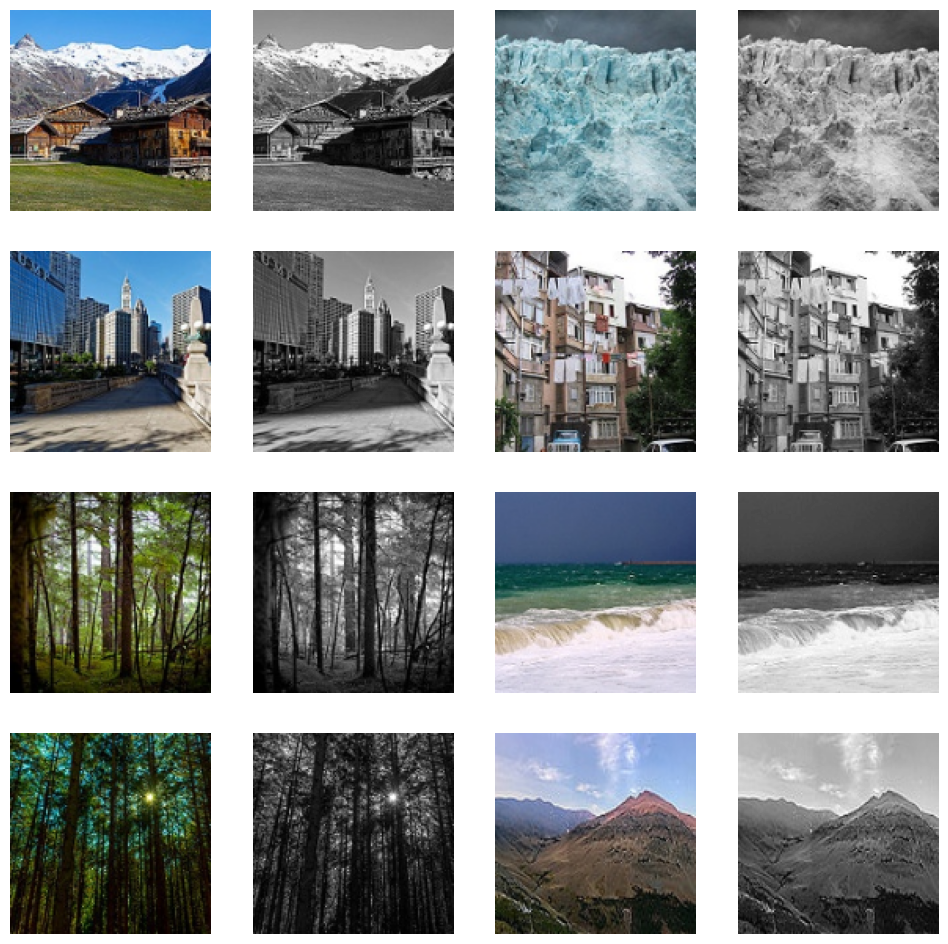

In [3]:
fig , ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    number = random.randint(0, color_images.shape[0]-1)
    number_2 = random.randint(0, color_images.shape[0]-1)
    ax[i, 0].imshow(color_images[number][:,:,::-1]/255)
    ax[i, 0].axis('off')
    ax[i, 1].imshow(gray_images[number], cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 2].imshow(color_images[number_2][:,:,::-1]/255)
    ax[i, 2].axis('off')
    ax[i, 3].imshow(gray_images[number_2], cmap='gray')
    ax[i, 3].axis('off')

In [4]:
x_trian, x_test, y_train, y_test = train_test_split(gray_images, color_images, test_size=0.15)

In [5]:
print(x_trian.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6059, 128, 128)
(6059, 128, 128, 3)
(1070, 128, 128)
(1070, 128, 128, 3)


In [6]:
x_train = x_trian / 127.5 -1
x_test = x_test / 127.5 - 1
y_train = y_train / 127.5 - 1
y_test = y_test / 127.5 -1

##  Generator Architecture (U-Net)

The Generator in the Pix2Pix model uses a **U-Net architecture** to translate a grayscale input image into a color image.

### Input and Output Shapes
- **Input:** 128x128x1 (grayscale image)
- **Output:** 128x128x3 (color image)

### Architecture Details

1. **Encoder (Downsampling)**
   - Applies several convolutional layers with stride 2 to reduce spatial dimensions.
   - Each step includes:
     - Conv2D
     - Batch Normalization
     - LeakyReLU activation
   - This captures the image features at multiple scales.

2. **Decoder (Upsampling)**
   - Uses transposed convolutions to increase spatial resolution back to original size.
   - Each step includes:
     - Conv2DTranspose
     - Batch Normalization
     - Dropout (in some layers to prevent overfitting)
     - ReLU activation
   - Reconstructs the image in RGB color space.

3. **Skip Connections**
   - Connect encoder layers directly to corresponding decoder layers.
   - Helps recover spatial details lost during downsampling by concatenating feature maps.

### Final Layer
- Outputs a 128x128x3 image.
- Uses a **tanh activation** to scale pixel values between -1 and 1.

---

This U-Net structure allows the generator to maintain both low-level spatial details and high-level context, resulting in accurate and detailed colorized images.

![](https://cafetadris.com/blog/wp-content/uploads/2024/04/sensors-23-00053-g001-1024x772.png)

In [7]:
def build_generator():
    inputs = Input(shape=(128, 128, 1))

    d1 = Conv2D(64, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(inputs)
    d1 = LeakyReLU()(d1)

    d2 = Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU()(d2)

    d3 = Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(d2)
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU()(d3)

    d4 = Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(d3)
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU()(d4)

    d5 = Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(d4)
    d5 = BatchNormalization()(d5)
    d5 = LeakyReLU()(d5)

    d6 = Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(d5)
    d6 = BatchNormalization()(d6)
    d6 = LeakyReLU()(d6)

    d7 = Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(d6)
    d7 = BatchNormalization()(d7)
    d7 = LeakyReLU()(d7)

    u1 = Conv2DTranspose(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(d7)
    u1 = BatchNormalization()(u1)
    u1 = Dropout(0.5)(u1)
    u1 = ReLU()(u1)
    u1 = Concatenate()([u1, d6])

    u2 = Conv2DTranspose(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(u1)
    u2 = BatchNormalization()(u2)
    u2 = Dropout(0.5)(u2)
    u2 = ReLU()(u2)
    u2 = Concatenate()([u2, d5])

    u3 = Conv2DTranspose(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(u2)
    u3 = BatchNormalization()(u3)
    u3 = Dropout(0.5)(u3)
    u3 = ReLU()(u3)
    u3 = Concatenate()([u3, d4])

    u4 = Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(u3)
    u4 = BatchNormalization()(u4)
    u4 = ReLU()(u4)
    u4 = Concatenate()([u4, d3])

    u5 = Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(u4)
    u5 = BatchNormalization()(u5)
    u5 = ReLU()(u5)
    u5 = Concatenate()([u5, d2])

    u6 = Conv2DTranspose(64, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(u5)
    u6 = BatchNormalization()(u6)
    u6 = ReLU()(u6)
    u6 = Concatenate()([u6, d1])

    output = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(u6)

    return Model(inputs=inputs, outputs=output)

generator = build_generator()
generator.summary()

I0000 00:00:1751226165.671123      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          1,024 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 64, 64)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 128)    │        131,072 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 256)    │        524,288 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 16, 16, 256)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 8, 8, 512)      │      2,097,152 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 512)      │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 8, 8, 512)      │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 4, 4, 512)      │      4,194,304 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 4, 4, 512)      │          2,048 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 4, 4, 512)      │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 2, 2, 512)      │      4,194,304 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 2, 2, 512)      │          2,048 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 41,836,803 (159.59 MB)

 Trainable params: 41,827,971 (159.56 MB)

 Non-trainable params: 8,832 (34.50 KB)

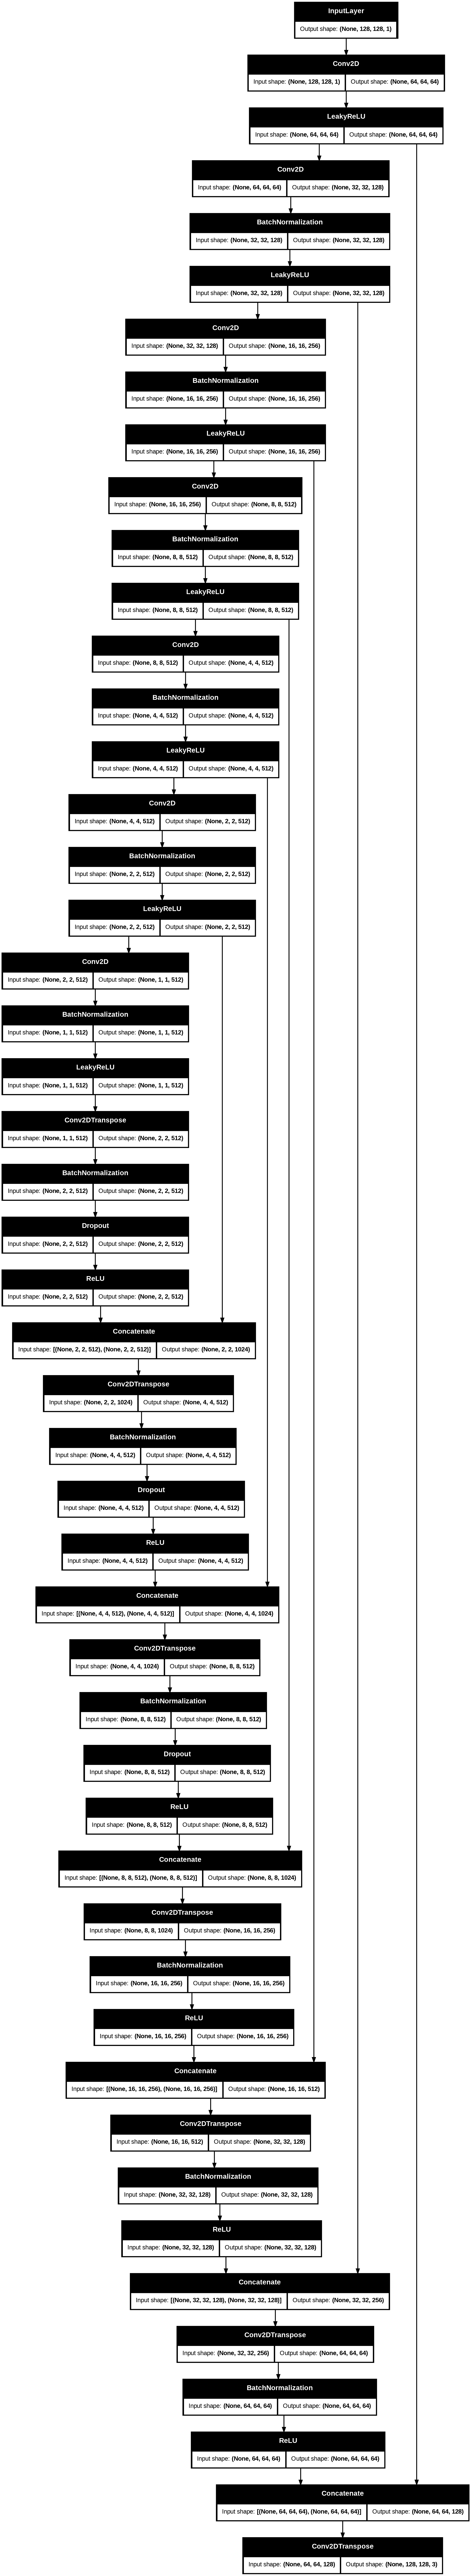

In [8]:
plot_model(generator, to_file='generator.png', show_shapes=True, expand_nested=True)

##  Discriminator and PatchGAN Explained

In the **Pix2Pix** architecture, the discriminator plays a crucial role in guiding the generator to produce realistic outputs. Instead of judging an entire image at once, Pix2Pix uses a specialized discriminator called **PatchGAN**.

---

### What is the Discriminator?

- The discriminator is a neural network trained to **distinguish between real and fake images**.
- In Pix2Pix, it receives **both the input image and the target image (real or generated)** concatenated together.
- Its job is to assess whether the generated output looks realistic given the input.

---

### What is PatchGAN?

- **PatchGAN** is a type of discriminator that focuses on **small image patches** instead of the whole image.
- Rather than outputting a single real/fake probability for the entire image, it outputs a matrix where each value corresponds to the realism of a small patch (e.g., 16x16 pixels).
- This patch-wise approach helps the discriminator focus on **local textures and details**.
- As a result, the generator learns to produce sharper, more detailed images that look realistic at the local patch level.

---

### How PatchGAN Works

- The discriminator applies convolutional layers to the concatenated input and output images.
- It progressively downsamples the image until it outputs a **feature map**, where each element corresponds to a patch's authenticity score.
- For example, for a 128x128 input, the output might be a 30x30 matrix, with each cell judging a 16x16 patch.

---

### Why Use PatchGAN?

- Encourages the generator to produce **high-frequency details** and **locally coherent textures**.
- Reduces the number of parameters compared to a discriminator judging the full image.
- Leads to better quality results in tasks like image-to-image translation, segmentation, and colorization.

---

### Summary

- The discriminator in Pix2Pix is a **PatchGAN** that assesses realism at the patch level.
- This helps the generator create outputs that are not only globally consistent but also rich in local detail.


In [9]:
def build_discriminator():
    inp = Input(shape=(128, 128, 1), name='input_image')
    tar = Input(shape=(128, 128, 3), name='target_image')

    x = Concatenate()([inp, tar])  # (128, 128, 4)

    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='sigmoid')(x)  # (16x16x1)

    return Model(inputs=[inp, tar], outputs=x, name='PatchGAN_Discriminator')

discriminator = build_discriminator()
discriminator.summary()

Model: "PatchGAN_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 128, 128, 4)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 64)     │          4,160 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 64, 64, 64)     │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 128)    │        131,200 │ leaky_re_lu_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 32, 32, 128)    │            512 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 256)    │        524,544 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 16, 16, 256)    │          1,024 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 16, 16, 256)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 16, 16, 512)    │      2,097,664 │ leaky_re_lu_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 16, 16, 512)    │          2,048 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_10            │ (None, 16, 16, 512)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 16, 16, 1)      │          8,193 │ leaky_re_lu_10[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,769,345 (10.56 MB)

 Trainable params: 2,767,553 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

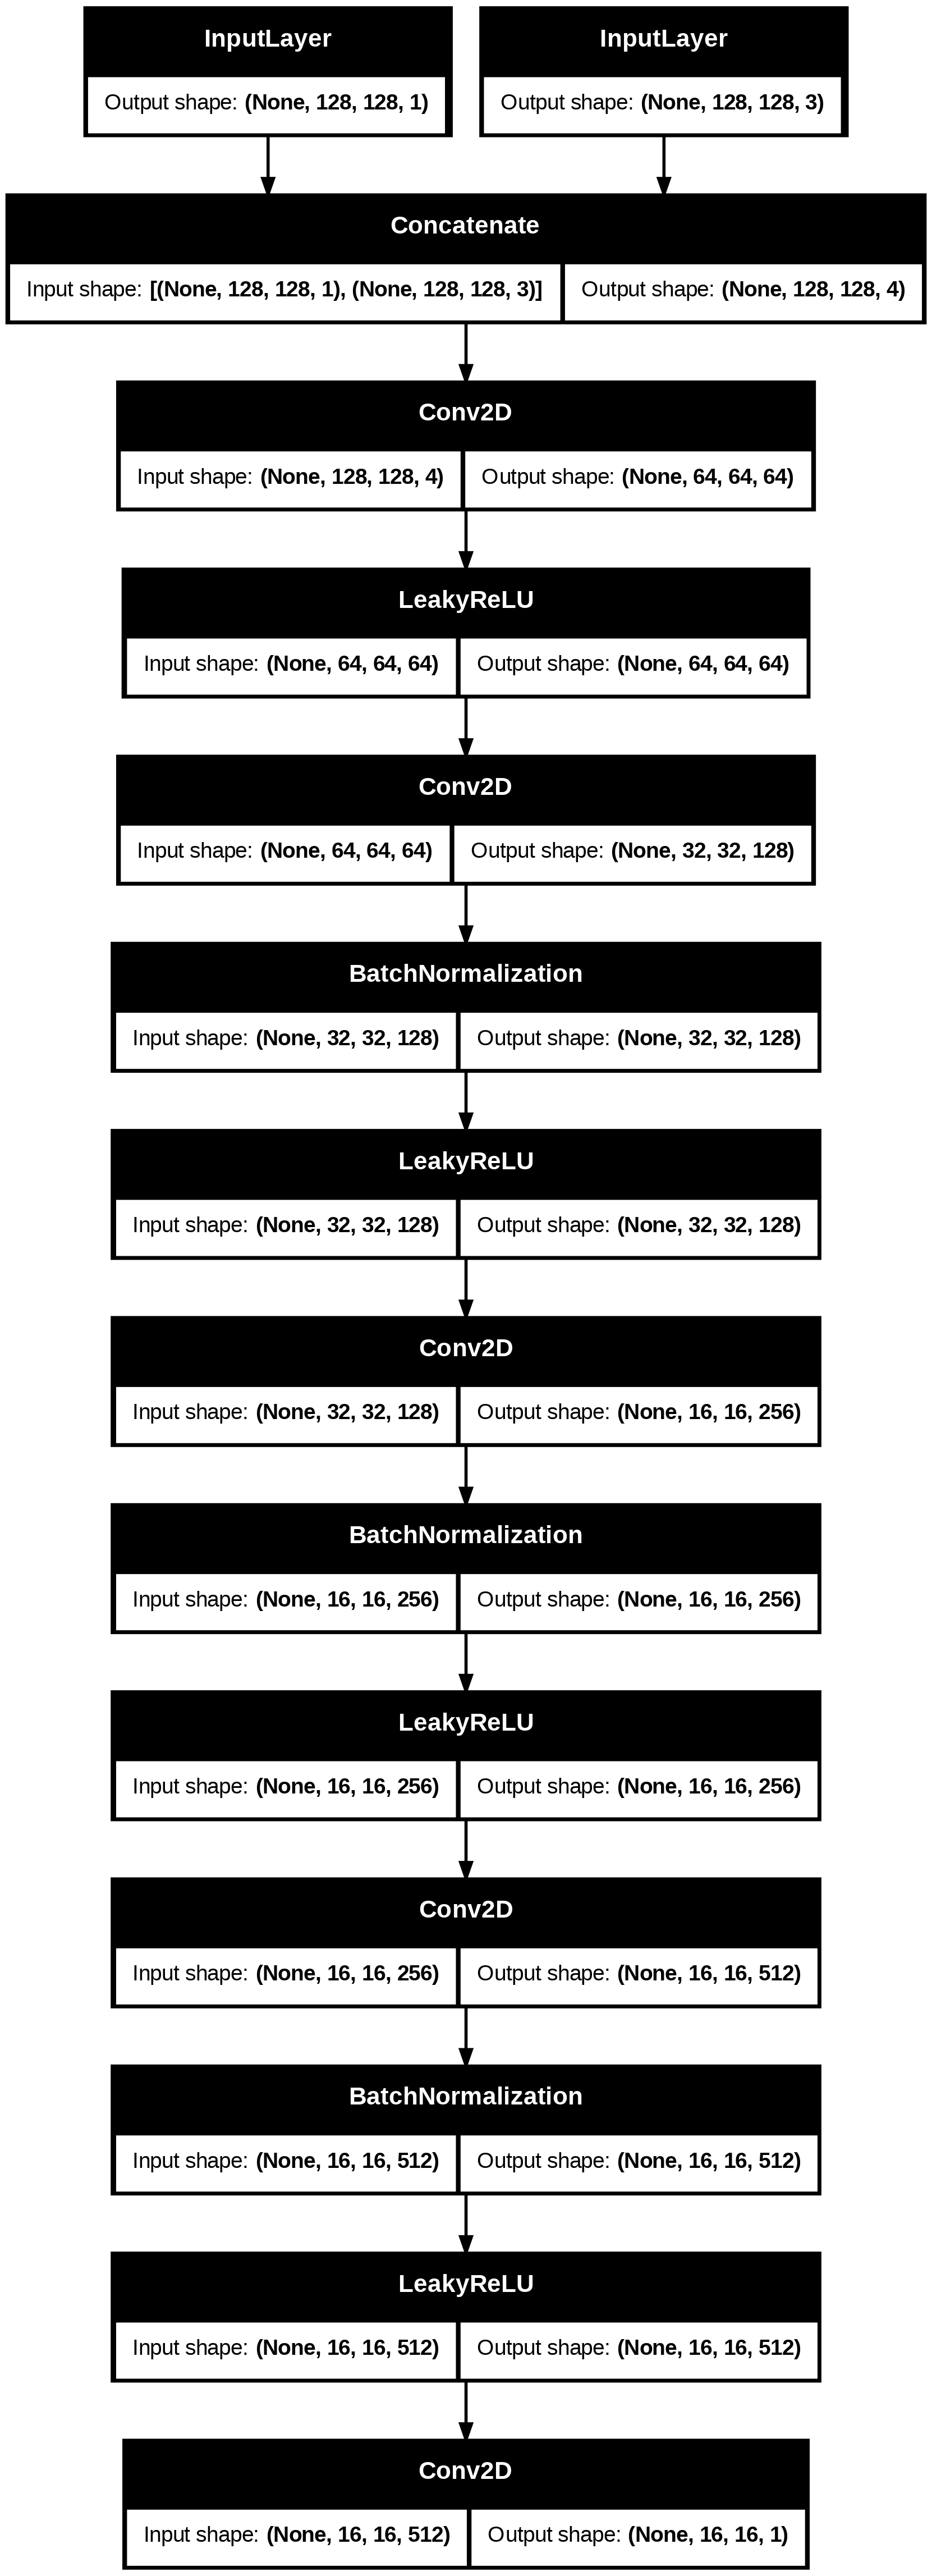

In [10]:
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, expand_nested=True)

##  Loss Functions

Pix2Pix uses a combination of two losses to train the model effectively:

- **Adversarial Loss (Binary Cross-Entropy):**  
  Encourages the generator to produce outputs that fool the discriminator, making generated images look realistic.

- **L1 Loss (Mean Absolute Error):**  
  Encourages the generated image to be close to the ground truth pixel-wise, promoting accurate reconstruction and reducing blurriness.

---

The total generator loss is a weighted sum of these two:
\[
\text{Generator Loss} = \text{Adversarial Loss} + \lambda \times \text{L1 Loss}
\]
where \(\lambda\) controls the balance between realism and accuracy.


In [11]:
loss_object = BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(disc_generated_output, gen_output, target):
    target = tf.cast(target, tf.float32)
    gen_output = tf.cast(gen_output, tf.float32)

    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)

    return total_gen_loss


generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train[..., np.newaxis], y_train)) \
    .shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)

##  Training Plan for Pix2Pix

Training a Pix2Pix model involves alternating updates between the **generator** and the **discriminator** to achieve realistic image translation.

---

### Step-by-Step Training Process:

1. **Prepare Input Pairs:**  
   Feed the model with paired data `(input_image, target_image)`. For example, grayscale images and their colorized versions.

2. **Generator Forward Pass:**  
   The generator takes the input image and produces a fake output image.

3. **Discriminator Training:**  
   - The discriminator is given both **real pairs** `(input_image, target_image)` labeled as real (1).  
   - And **fake pairs** `(input_image, generated_image)` labeled as fake (0).  
   - The discriminator learns to distinguish between real and fake pairs by minimizing its loss.

4. **Generator Training:**  
   - The generator aims to fool the discriminator, so it tries to generate images that the discriminator classifies as real.  
   - The generator also minimizes the L1 loss to make its output close to the target image.  
   - The combined generator loss encourages producing images that are both realistic and accurate.

5. **Repeat for Epochs:**  
   This alternating update continues for multiple epochs over the dataset until the model converges.

---

### Notes:

- Use **batch training** for efficient computation.  
- Apply **data normalization** to inputs and outputs (e.g., scale pixel values between -1 and 1).  
- Monitor both generator and discriminator losses to avoid overfitting or mode collapse.

---

This process allows the generator and discriminator to improve iteratively, resulting in high-quality image translations.


In [13]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


def train(dataset, epochs):
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        bar = tqdm(dataset, desc='Training', unit='step')

        for input_image, target in bar:
            gen_loss, disc_loss = train_step(input_image, target)

            # Update the bar description with current losses
            bar.set_postfix({
                'Gen Loss': f"{gen_loss.numpy():.4f}",
                'Disc Loss': f"{disc_loss.numpy():.4f}"
            })

In [14]:
EPOCHS = 50

train(train_dataset, EPOCHS)


Epoch 1/50


Training:   0%|          | 0/95 [00:00<?, ?step/s]/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
E0000 00:00:1751226193.749881      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1751226194.582392      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
Training: 100%|██████████| 95/95 [00:57<00:00,  1.64step/s, Gen Loss=14.5404, Disc Loss=1.0482]



Epoch 2/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=12.6844, Disc Loss=1.2558]



Epoch 3/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=13.5925, Disc Loss=0.9245]



Epoch 4/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=13.7960, Disc Loss=2.0051]



Epoch 5/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=12.3027, Disc Loss=1.0683]



Epoch 6/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.15step/s, Gen Loss=12.5424, Disc Loss=1.5094]



Epoch 7/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=11.4201, Disc Loss=1.4574]



Epoch 8/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=10.9824, Disc Loss=1.3443]



Epoch 9/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.13step/s, Gen Loss=10.1891, Disc Loss=1.0804]



Epoch 10/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=9.3712, Disc Loss=1.1250]



Epoch 11/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.13step/s, Gen Loss=8.4286, Disc Loss=1.3189]



Epoch 12/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=8.9467, Disc Loss=1.4389]



Epoch 13/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=9.7699, Disc Loss=0.9494]



Epoch 14/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=8.9494, Disc Loss=1.5003]



Epoch 15/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=8.3012, Disc Loss=1.1175]



Epoch 16/50


Training: 100%|██████████| 95/95 [00:40<00:00,  2.32step/s, Gen Loss=8.1576, Disc Loss=1.2750]



Epoch 17/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=8.2661, Disc Loss=1.3983]



Epoch 18/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=7.4701, Disc Loss=1.4451]



Epoch 19/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=7.6834, Disc Loss=1.2447]



Epoch 20/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=8.2780, Disc Loss=1.0076]



Epoch 21/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.13step/s, Gen Loss=7.9143, Disc Loss=1.1981]



Epoch 22/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=7.6424, Disc Loss=1.2910]



Epoch 23/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=7.8461, Disc Loss=1.2645]



Epoch 24/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.9320, Disc Loss=1.3622]



Epoch 25/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.13step/s, Gen Loss=7.8718, Disc Loss=1.2618]



Epoch 26/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=7.0906, Disc Loss=1.3017]



Epoch 27/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.13step/s, Gen Loss=6.8361, Disc Loss=1.1530]



Epoch 28/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=7.4945, Disc Loss=1.2846]



Epoch 29/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.13step/s, Gen Loss=7.4135, Disc Loss=1.3372]



Epoch 30/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.4687, Disc Loss=1.2704]



Epoch 31/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=7.1162, Disc Loss=1.2916]



Epoch 32/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.8120, Disc Loss=1.3291]



Epoch 33/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.7702, Disc Loss=1.2665]



Epoch 34/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.13step/s, Gen Loss=6.4262, Disc Loss=1.1951]



Epoch 35/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.15step/s, Gen Loss=6.9677, Disc Loss=1.3318]



Epoch 36/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.2498, Disc Loss=1.3101]



Epoch 37/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.13step/s, Gen Loss=6.3454, Disc Loss=1.1641]



Epoch 38/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.6028, Disc Loss=1.2749]



Epoch 39/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.7748, Disc Loss=1.2067]



Epoch 40/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.2753, Disc Loss=1.1834]



Epoch 41/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=5.9385, Disc Loss=1.2221]



Epoch 42/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.3107, Disc Loss=1.2331]



Epoch 43/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.8921, Disc Loss=1.4132]



Epoch 44/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.13step/s, Gen Loss=6.6097, Disc Loss=1.1570]



Epoch 45/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=5.7998, Disc Loss=1.1576]



Epoch 46/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=5.8887, Disc Loss=1.3934]



Epoch 47/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.4548, Disc Loss=1.1266]



Epoch 48/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.5761, Disc Loss=1.2034]



Epoch 49/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.14step/s, Gen Loss=6.9717, Disc Loss=1.0600]



Epoch 50/50


Training: 100%|██████████| 95/95 [00:30<00:00,  3.15step/s, Gen Loss=5.3066, Disc Loss=1.5794]


##  Visualizing Results

After training the Pix2Pix model, it’s important to visually inspect the output to evaluate performance qualitatively.

### How to Plot Results:

1. **Select some test images** from your validation or test set.
2. **Use the trained generator** to predict the output (e.g., colorized image) for each input.
3. **Display the input image, generated output, and ground truth side-by-side** for easy comparison.



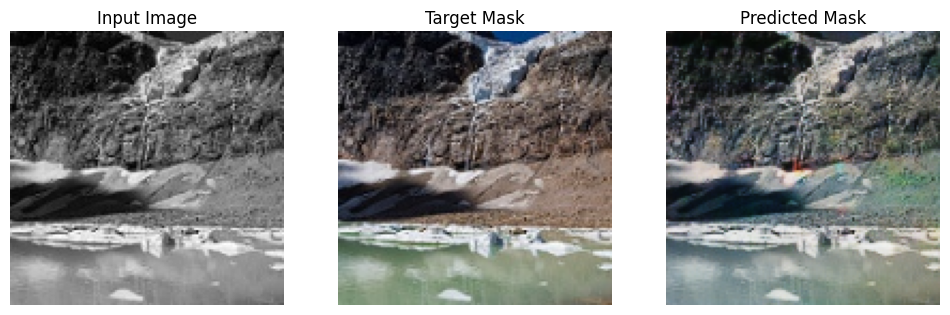

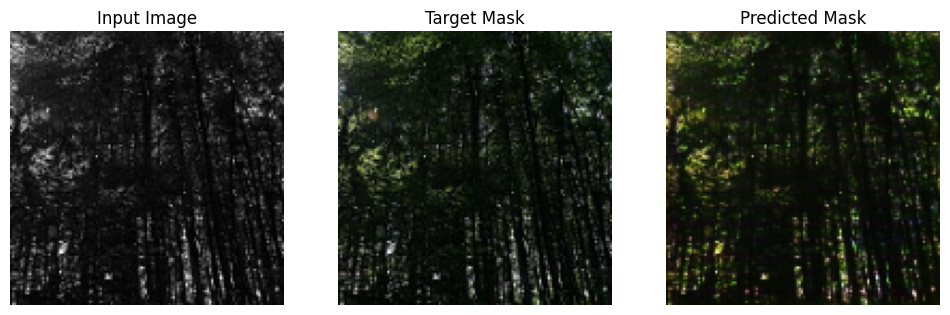

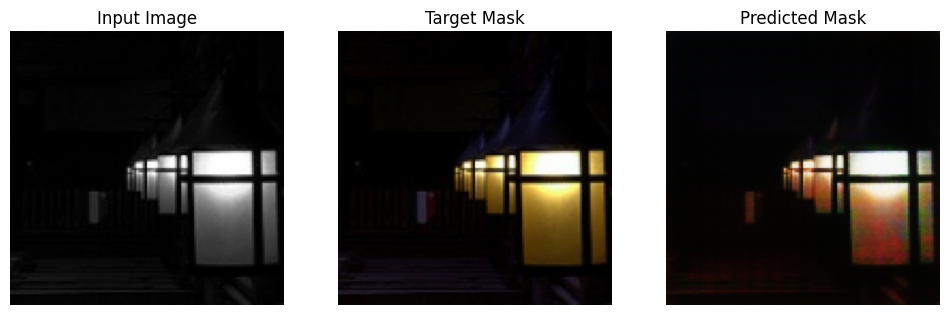

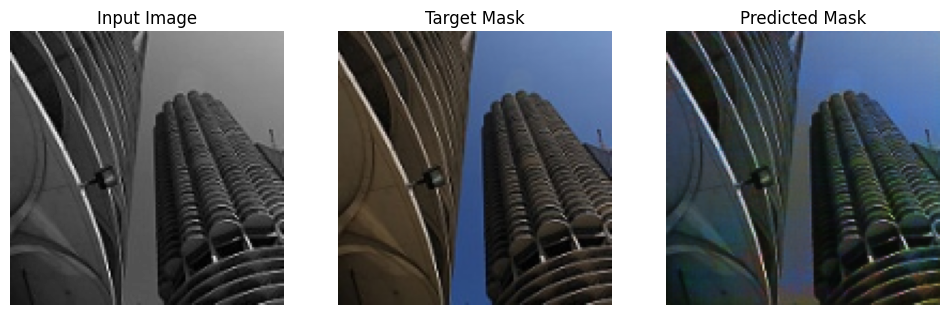

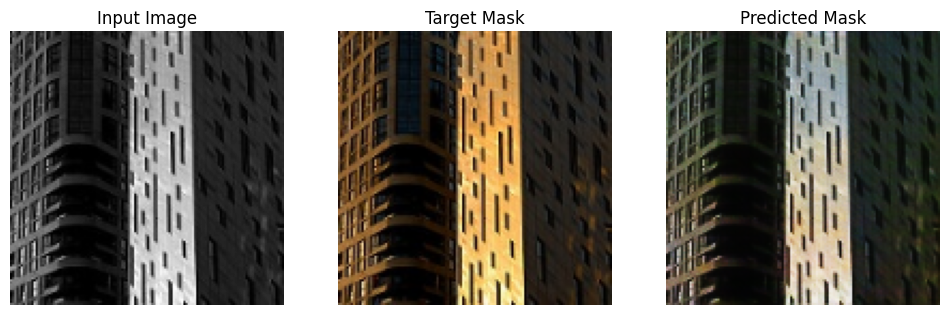

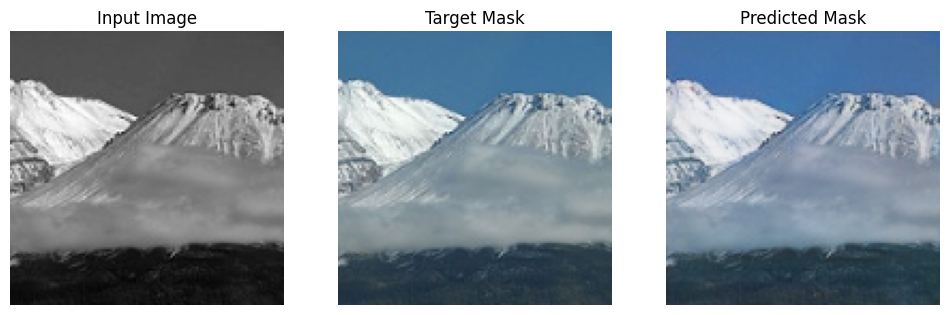

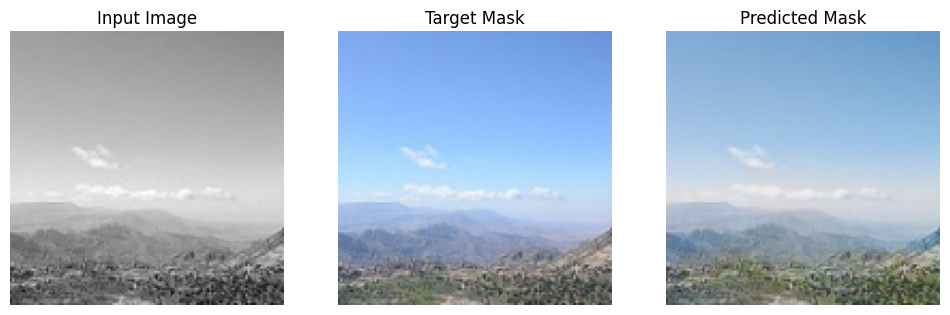

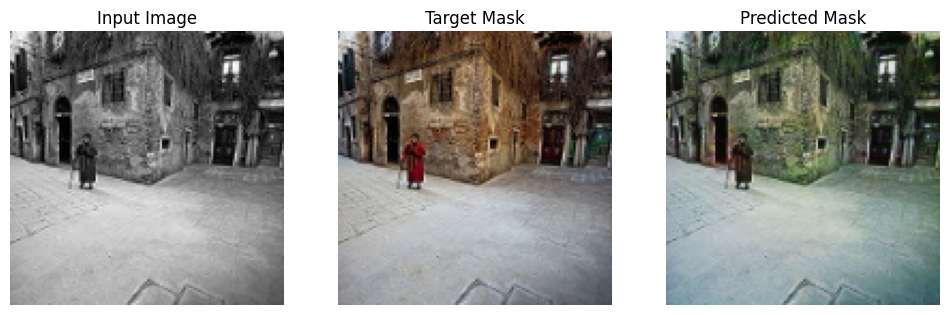

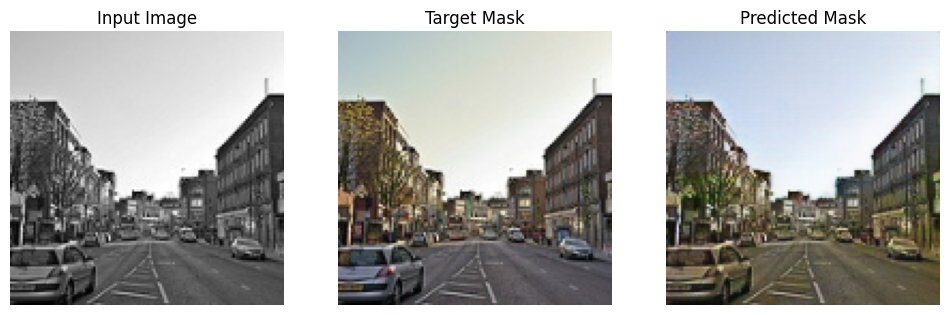

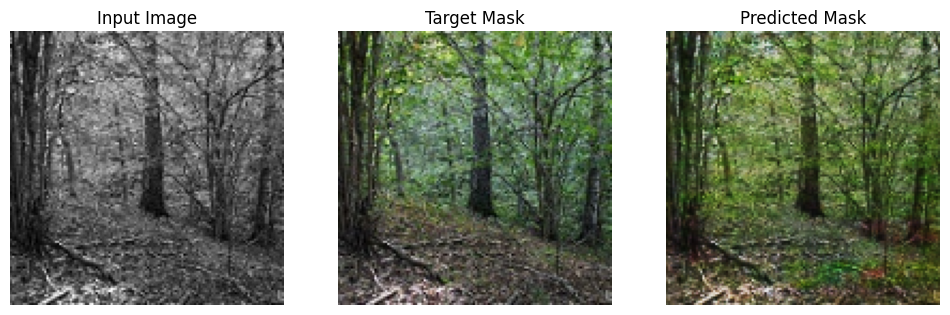

In [15]:
def display_sample(generator, number):
    img = x_test[number]
    prediction = generator(tf.expand_dims(img, axis=0), training=False)
    fainal_predict = ((prediction[0][:,:,::-1]+1)*127.5)/255

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Target Mask")
    plt.imshow(((y_test[number][:,:,::-1]+1) * 127.5)/255)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(fainal_predict)
    plt.axis('off')

    plt.show()

for i in range(10):
    number = random.randint(0, x_test.shape[0])
    display_sample(generator, number)

In [16]:
generator.save('/kaggle/working/model.h5')

---

## 🙏 Thank You!

Thank you for following along this Pix2Pix project!  
Feel free to reach out if you have any questions or want to collaborate.  
Happy coding and good luck with your image translation tasks! 🚀✨
